In [31]:
# importing necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [32]:
#Load Dataset
data=pd.read_csv('./CancerPScreen_Clean.csv')
data.head()

,Unnamed: 0,V1,V2,V3,V4,V5,V6,V7,V8,V9,Class
0,0,137.573925,151.719162,0.596020,23.629505,7.030695,0.580842,20.306659,40.032476,59.758293,0.0
1,1,116.496435,144.131710,0.559442,21.142454,7.302688,1.792108,16.222173,30.652238,45.082303,0.0
2,2,226.076027,194.559764,0.594095,29.937782,9.526411,10.851462,28.283713,45.715964,63.148214,1.0
3,3,100.359149,134.248998,0.555051,20.580689,5.855500,9.848190,20.564519,31.280848,41.997178,1.0
4,4,131.986704,150.623324,0.579484,23.986106,7.273814,30.388115,22.448860,14.509605,6.570351,1.0


In [33]:
#Remove the unnamed column
clean_data=data[['V1', 'V2', 'V3','V4', 'V5', 'V6','V7', 'V8', 'V9','Class']].copy()
clean_data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,Class
0,137.573925,151.719162,0.596020,23.629505,7.030695,0.580842,20.306659,40.032476,59.758293,0.0
1,116.496435,144.131710,0.559442,21.142454,7.302688,1.792108,16.222173,30.652238,45.082303,0.0
2,226.076027,194.559764,0.594095,29.937782,9.526411,10.851462,28.283713,45.715964,63.148214,1.0
3,100.359149,134.248998,0.555051,20.580689,5.855500,9.848190,20.564519,31.280848,41.997178,1.0
4,131.986704,150.623324,0.579484,23.986106,7.273814,30.388115,22.448860,14.509605,6.570351,1.0


In [34]:
#check number of rows and datatype
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1560 entries, 0 to 1559
Data columns (total 10 columns):
V1       1560 non-null float64
V2       1560 non-null float64
V3       1560 non-null float64
V4       1560 non-null float64
V5       1560 non-null float64
V6       1560 non-null float64
V7       1560 non-null float64
V8       1560 non-null float64
V9       1560 non-null float64
Class    1560 non-null float64
dtypes: float64(10)
memory usage: 122.0 KB


Class Split
1.0    1020
0.0     540
Name: Class, dtype: int64


Text(0, 0.5, 'Count')

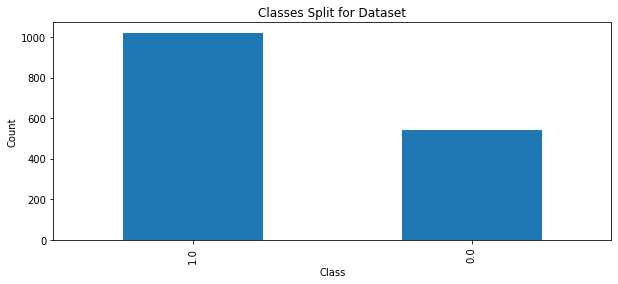

In [35]:
#Class Balance
print('Class Split')
print(clean_data['Class'].value_counts())
clean_data['Class'].value_counts().plot.bar(figsize=(10,4),title='Classes Split for Dataset')
plt.xlabel('Class')
plt.ylabel('Count')

In [36]:
#Create x and y variables
x = clean_data.drop('Class', axis=1).values
Y = clean_data['Class'].values

#Create Training Set
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,Y,test_size = 0.2,stratify=Y,random_state = 100)

#Fix the imbalanced Classes
from imblearn.over_sampling import SMOTE
smt=SMOTE(random_state=100)
x_train_smt,y_train_smt = smt.fit_resample(x_train,y_train)

#Scale the Data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_train2 = sc.fit_transform(x_train_smt)
x_test2 = sc.fit_transform(x_test)



In [37]:
#Current Class Balance - Test Data
print('Current - Class Split')
num_zeros = (y_train_smt == 0).sum()
num_ones = (y_train_smt == 1).sum()
print('No-Cancer -',  num_zeros)
print('Cancer -',  num_ones)

Current - Class Split
No-Cancer - 816
Cancer - 816


In [38]:
#Load Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# Construct some pipelines 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

#Create Pipeline

pipeline =[]

pipe_logreg = Pipeline([('scl', StandardScaler()),
                    ('clf', LogisticRegression(solver='lbfgs',class_weight='balanced',
                                               random_state=100))])
pipeline.insert(0,pipe_logreg)

pipe_knn = Pipeline([('scl', StandardScaler()),
                    ('clf', KNeighborsClassifier(n_jobs=-1))])
pipeline.insert(1,pipe_knn)


pipe_dt = Pipeline([('scl', StandardScaler()),
                    ('clf', DecisionTreeClassifier(random_state=100))])
pipeline.insert(2,pipe_dt)

pipe_rdf = Pipeline([('scl', StandardScaler()),
                    ('clf', RandomForestClassifier(n_estimators=100,random_state=100))])
pipeline.insert(3,pipe_rdf)



# Set grid search params 

modelpara =[]

param_gridlogreg = {'clf__C': [0.01, 0.1, 1, 10, 100], 
                    'clf__penalty': ['l2']}
modelpara.insert(0,param_gridlogreg)


param_range_k = range(1, 10) 
param_gridknn = {'clf__n_neighbors':param_range_k}
modelpara.insert(1,param_gridknn)

In [39]:
#Define Plot for learning curve

from sklearn.model_selection import learning_curve
from sklearn.utils import shuffle
X_shuffle, y_shuffle = shuffle(x_train2, y_train_smt)


def plot_learning_curves(model):
    train_sizes, train_scores, test_scores = learning_curve(estimator=model,
                                                            X=X_shuffle, 
                                                            y=y_shuffle,
                                                            train_sizes= np.linspace(0.1, 1.0, 10),
                                                            cv=10,
                                                            scoring='recall_weighted',
                                                            n_jobs=1,random_state=100)
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    
    plt.plot(train_sizes, train_mean,color='blue', marker='o', 
             markersize=5, label='training recall')
    plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std,
                     alpha=0.15, color='blue')

    plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5,
             label='validation recall')
    plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std,
                     alpha=0.15, color='green')
    plt.grid(True)
    plt.xlabel('Number of Training Samples')
    plt.ylabel('Recall')
    plt.legend(loc='best')
    plt.ylim([0.5, 1.01])
    plt.show()


 KNN Learning Curve


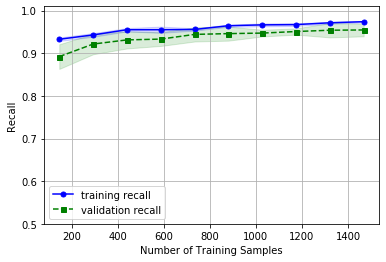


 Decision Tree Learning Curve


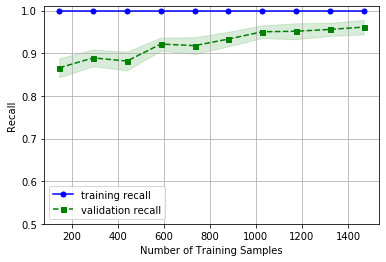


 RDF Learning Curve


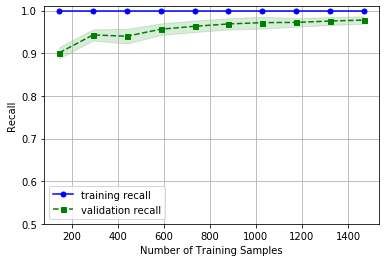


 Logistic Regression Learning Curve


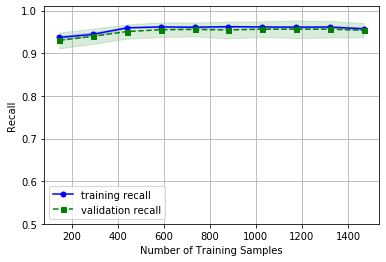

In [40]:
#Plot Learning Curve

print('\n KNN Learning Curve')
plot_learning_curves(pipe_knn)
print('\n Decision Tree Learning Curve')
plot_learning_curves(pipe_dt)
print('\n RDF Learning Curve')
plot_learning_curves(pipe_rdf)
print('\n Logistic Regression Learning Curve')
plot_learning_curves(pipe_logreg)


Model Evaluation - Recall Weighted
Logistic Regression 0.96 +/- 0.02
KNN 0.96 +/- 0.02
Decision Tree 0.96 +/- 0.01
RDF 0.98 +/- 0.01




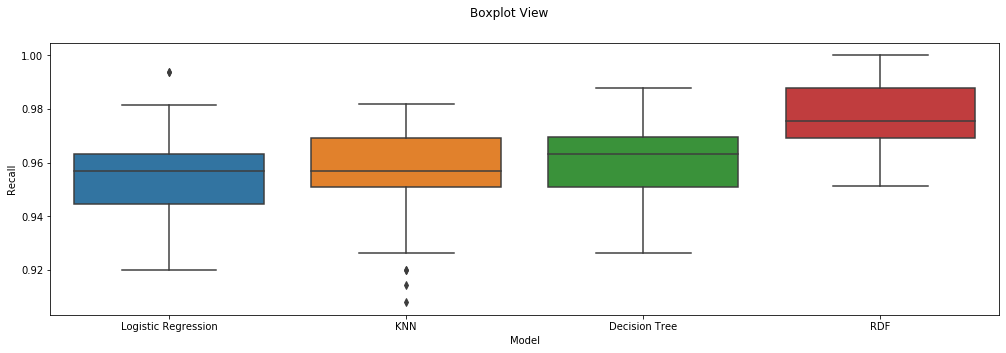

In [41]:
#Model Analysis
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score

models=[]
models.append(('Logistic Regression',pipe_logreg))
models.append(('KNN',pipe_knn))
models.append(('Decision Tree',pipe_dt))
models.append(('RDF',pipe_rdf))


  

#Model Evaluation
results =[]
names=[]
scoring ='recall_weighted'
print('Model Evaluation - Recall Weighted')
for name, model in models:
    rkf=RepeatedKFold(n_splits=10, n_repeats=5, random_state=100)
    cv_results = cross_val_score(model,x_train2,y_train_smt,cv=rkf,scoring=scoring)
    results.append(cv_results)
    names.append(name)
    print('{} {:.2f} +/- {:.2f}'.format(name,cv_results.mean(),cv_results.std()))
print('\n')

fig = plt.figure(figsize=(17,5))
fig.suptitle('Boxplot View')
ax = fig.add_subplot(111)
sns.boxplot(data=results)
ax.set_xticklabels(names)
plt.ylabel('Recall')
plt.xlabel('Model')
plt.show()

In [42]:
# Base Logistical Models
from sklearn.metrics import classification_report, confusion_matrix  
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

target_names=['No-Cancer','Cancer']

for name,method in [('Logistic Regression',LogisticRegression(solver='liblinear',random_state=100)),
                    ('KNN',KNeighborsClassifier()),
                    ('RDF',RandomForestClassifier())
                    ]: 
    method.fit(x_train2,y_train_smt)
    predict = method.predict(x_test2)
    print('Confusion Matrix') 
    print(confusion_matrix(y_test,predict))  
    print('\nEstimator: {}'.format(name)) 
    print(classification_report(y_test,predict,target_names=target_names))

Confusion Matrix
[[104   4]
 [ 30 174]]

Estimator: Logistic Regression
              precision    recall  f1-score   support

   No-Cancer       0.78      0.96      0.86       108
      Cancer       0.98      0.85      0.91       204

    accuracy                           0.89       312
   macro avg       0.88      0.91      0.89       312
weighted avg       0.91      0.89      0.89       312

Confusion Matrix
[[105   3]
 [ 20 184]]

Estimator: KNN
              precision    recall  f1-score   support

   No-Cancer       0.84      0.97      0.90       108
      Cancer       0.98      0.90      0.94       204

    accuracy                           0.93       312
   macro avg       0.91      0.94      0.92       312
weighted avg       0.93      0.93      0.93       312

Confusion Matrix
[[107   1]
 [ 19 185]]

Estimator: RDF
              precision    recall  f1-score   support

   No-Cancer       0.85      0.99      0.91       108
      Cancer       0.99      0.91      0.95       204

C:\Users\tiwar\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [29]:


#Define Gridsearch Function

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix  

def Gridsearch_cv(model, params):
    
    #Cross-validation Function
    cv2=RepeatedKFold(n_splits=10, n_repeats=5, random_state=100)
        
    #GridSearch CV
    gs_clf = GridSearchCV(model, params, n_jobs=1, cv=cv2,scoring='recall_weighted')
    gs_clf = gs_clf.fit(x_train2, y_train_smt)
    model = gs_clf.best_estimator_
    
    #Nested CV
    x_2 = sc.fit_transform(x)
    scoreACC = cross_val_score(gs_clf, x_2, Y, 
                             scoring='accuracy', cv=5,
                             n_jobs= -1)
    
    scorePM = cross_val_score(gs_clf, x_2, Y, 
                             scoring='precision_weighted', cv=5,
                             n_jobs= -1)
    
    scoreRM = cross_val_score(gs_clf, x_2, Y, 
                             scoring='recall_weighted', cv=5,
                             n_jobs= -1)
    
    # Use best model and test data for final evaluation
    y_pred = model.predict(x_test2)
    
    #Identify Best Parameters to Optimize the Model
    bestpara=str(gs_clf.best_params_)
    
    #Output Heading
    print('\nOptimized Model')
    print('\nModel Name:',str(pipeline.named_steps['clf']))
        
    #Output Validation Statistics
    target_names=['No-Cancer','Cancer']
    print('\nBest Parameters:',bestpara)
    print('\n', confusion_matrix(y_test,y_pred))  
    print('\n',classification_report(y_test,y_pred,target_names=target_names))
    print('\nNestedCV Accuracy(weighted) :{:0.2f} +/-{:0.2f} '.format(np.mean(scoreACC),np.std(scoreACC)))
    print('NestedCV Precision(weighted) :{:0.2f} +/-{:0.2f} '.format(np.mean(scorePM),np.std(scorePM)))
    print('NestedCV Recall(weighted) :{:0.2f} +/-{:0.2f} '.format(np.mean(scoreRM),np.std(scoreRM)))
    print('\n')
    
    #Transform the variables into binary (0,1) - ROC Curve
    from sklearn import preprocessing
    Forecast1=pd.DataFrame(y_pred)
    Outcome1=pd.DataFrame(y_test)
    lb1 = preprocessing.LabelBinarizer()
    OutcomeB1 =lb1.fit_transform(Outcome1)
    ForecastB1 = lb1.fit_transform(Forecast1)
    
    #Setup the ROC Curve
    from sklearn.metrics import roc_curve, auc
    from sklearn import metrics
    fpr, tpr, threshold = metrics.roc_curve(OutcomeB1, ForecastB1)
    roc_auc = metrics.auc(fpr, tpr)
    print('ROC Curve')
    #Plot the ROC Curve
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()   



Optimized Model

Model Name: LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=100, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Best Parameters: {'clf__C': 1, 'clf__penalty': 'l2'}

 [[104   4]
 [ 30 174]]

               precision    recall  f1-score   support

   No-Cancer       0.78      0.96      0.86       108
      Cancer       0.98      0.85      0.91       204

    accuracy                           0.89       312
   macro avg       0.88      0.91      0.89       312
weighted avg       0.91      0.89      0.89       312


NestedCV Accuracy(weighted) :0.95 +/-0.02 
NestedCV Precision(weighted) :0.95 +/-0.01 
NestedCV Recall(weighted) :0.95 +/-0.02 


ROC Curve


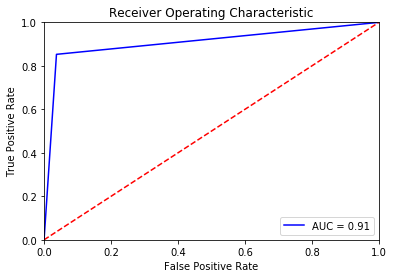


Optimized Model

Model Name: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
                     weights='uniform')

Best Parameters: {'clf__n_neighbors': 1}

 [[108   0]
 [  7 197]]

               precision    recall  f1-score   support

   No-Cancer       0.94      1.00      0.97       108
      Cancer       1.00      0.97      0.98       204

    accuracy                           0.98       312
   macro avg       0.97      0.98      0.98       312
weighted avg       0.98      0.98      0.98       312


NestedCV Accuracy(weighted) :0.94 +/-0.04 
NestedCV Precision(weighted) :0.95 +/-0.03 
NestedCV Recall(weighted) :0.94 +/-0.04 


ROC Curve


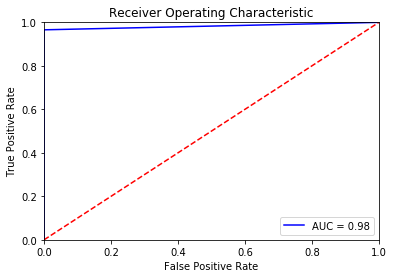

In [30]:
#Run Models

for pipeline, modelpara in zip(pipeline,modelpara):
    Gridsearch_cv(pipeline,modelpara)